In [2]:
from scipy.io import readsav
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import requests
from bs4 import BeautifulSoup

import urllib.request
#from urllib import urlopen

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import MaxNLocator

#import seaborn.apionly as sns; sns.set()

from spacepy import pycdf

from sklearn.utils import shuffle

Read in SEP event list

In [8]:
#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
#orig_data = pd.read_csv("AllEvtsShuffled_1986_2004.csv")

#read in the original Balch SEP event list with added CME speed and GOES T and EM
#orig_data = pd.read_excel("ctrlevents.v8p.xls")

#read in the shuffled dataframe of original sep+ctrl events from 1986 - 2004
data = pd.read_csv("AllEvtsShuffled_1986_2004_t_em.csv")

data.FlrOnset = pd.to_datetime(data.FlrOnset)
data.Flrendtime = pd.to_datetime(data.Flrendtime)
data.Flrmaxtime = pd.to_datetime(data.Flrmaxtime)

#unshuffle the data
data.sort_values(by = 'FlrOnset', inplace = True)
data.reset_index(inplace = True)
data.drop(columns = ['index', 'Unnamed: 0'], inplace = True)

Get the Wind WAVES RAD1 1 MHz fluence 

In [9]:
#pull out just the SEP events
#seps = orig_data.query('sep == 1.0')
#seps['1MHz_fluence'] = np.nan
#seps['1MHz_close_freq'] = np.nan

data['1MHz_fluence'] = np.nan
data['1MHz_close_freq'] = np.nan

for i in range(len(data[0:-2])):
    
    if data.iloc[i].FlrOnset.year > 1994:
        
        #print(orig_data.FlrOnset.iloc[i], orig_data.Flrendtime.iloc[i])
        
        #read the wind WAVES RAD1 CDF files
        df, freq = read_rad1(data.iloc[i])

        #integrate closest frequency channel to 1MHz from flare start time - 10 mins, to
        #flare peak time + 10 mins
        J, closest_freq = rad1_1mhz_integrate(data.iloc[i], df, freq)

        #print(type(J))
        
        data['1MHz_fluence'].iloc[i] = J
        data['1MHz_close_freq'].iloc[i] = closest_freq

        #make a plot
        #print(seps.FlrOnset.iloc[i], seps.Flrendtime.iloc[i])
        #print('J: %.2E' % J)
        #plot_rad1(df, st = seps.FlrOnset.iloc[i], et = seps.Flrendtime.iloc[i], peak  = seps.Flrmaxtime.iloc[i])



/Users/hazelbain/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


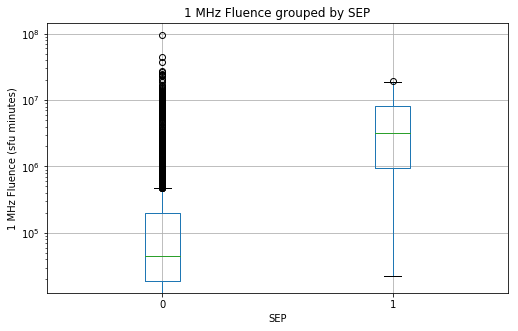

In [10]:
f, ax = plt.subplots(1,1, figsize = (8, 5))
data.boxplot(column=['1MHz_fluence'], by = 'sep', ax = ax)
ax.set_yscale('log')
ax.set_title('1 MHz Fluence grouped by SEP')
plt.suptitle(" ")
ax.set_ylabel('1 MHz Fluence (sfu minutes)')
ax.set_xlabel('SEP')
plt.show()

Save the data

In [78]:
#shuffle the events so they are not organized 
data_sh = shuffle(data)

#save the shuffled dataframe 
data_sh.to_csv("AllEvtsShuffled_1986_2004_t_em_1mhz.csv")

In [79]:
list(data)

['FlrOnset',
 'Flrmaxtime',
 'Flrendtime',
 'FlrPeakFlux',
 'xrscls',
 'ocls',
 'optlocation',
 'region',
 'Rpatrol',
 'TypeII',
 'TII_duration',
 'TypeIV',
 'TIV_duration',
 'CME_Patrol',
 'CME_onset',
 'CME_speed',
 'Satellite',
 'FlrHpTime',
 'FlrIntFlux',
 'FlrIntFlux2',
 'Association',
 'S1onset',
 'S2onset',
 'S3onset',
 'S4onset',
 'S5onset',
 'GT100onset',
 'sep',
 'tchianti',
 'emchianti',
 '1MHz_fluence',
 '1MHz_close_freq']

### Util Functions

Run these functions first

In [3]:
def plot_rad1(df, st, et, peak):
    
    """Plot of Wind WAVES RAD1 data"""

    #print(st,et)
    
    #pull out the intensity data (dropping the time column from the dataframe)
    intensity = df[list(df)[1::]]

    #add +/- 2 hours to the flare time window
    st1 = st - timedelta(seconds = 60*60*2)
    et1 = et + timedelta(seconds = 60*60*2)

    #print(st1,et1)
    
    #find the corresponding time in the data
    st_data = df.query('time >= "'+datetime.strftime(st1, "%Y-%m-%d %H:%M:%S")+'"')
    et_data = df.query('time >= "'+datetime.strftime(et1, "%Y-%m-%d %H:%M:%S")+'"')

    #convert to mdates
    st2 = mdates.date2num(st_data.time.iloc[0])
    et2 = mdates.date2num(et_data.time.iloc[0])
    
    #get the indices for the intensity data
    stind = st_data.index[0]
    etind = et_data.index[0]

    #closest frequency channel to 1 MHz
    ind1000 = np.argmin(np.abs(freq - 1000))
    indstr = str(freq[ind1000]) + 'kHz'
    
    #plot setup
    myFmt = mdates.DateFormatter('%H:%M')
    minorLocator   = MultipleLocator(0.1)

    f, (ax0, ax1) = plt.subplots(1,2, figsize = (15,5))
    
    #spectrogram
    ax0.imshow(np.transpose(intensity.iloc[stind:etind]), interpolation='nearest', cmap='jet', aspect = 'auto',\
                     extent = [st2, et2, freq[0],freq[-1]])
    ax0.set_xlim([st2, et2])
    ax0.xaxis.set_major_formatter(myFmt)
    ax0.xaxis.set_major_locator( MaxNLocator(integer=True) )
    ax0.xaxis.set_minor_locator(minorLocator)
    ax0.set_xlabel("Start Time "+str(df.time.iloc[stind])+" (UTC)")
    ax0.set_ylabel("Frequency")
    ax0.set_title("Wind WAVES RAD1")

    ax0.axvline(st,c = 'w', linestyle = '--')
    ax0.axvline(et,c='w', linestyle = '--')
    ax0.axhline(1000,c = 'w', linestyle = '--')
    
    #1 MHz    
    ax1.plot(df.time, df[indstr])
    ax1.set_xlim([st2, et2])
    ax1.set_ylim(bottom = 0)
    ax1.set_ylim(top = np.max(df[indstr].iloc[stind:etind])+0.1*np.max(df[indstr].iloc[stind:etind]))
    ax1.xaxis.set_major_formatter(myFmt)
    ax1.xaxis.set_major_locator( MaxNLocator(integer=True) )
    ax1.xaxis.set_minor_locator(minorLocator)
    ax1.set_xlabel("Start Time "+str(df.time.iloc[stind])+" (UTC)")
    ax1.set_ylabel("Intensity")
    ax1.set_title("Wind WAVES RAD1 1 MHz")
    
    ax1.axvline(st,c = 'black', linestyle = '--')
    ax1.axvline(et,c='black', linestyle = '--')

    ax1.axvline(st - timedelta(seconds = 10*60), c = 'red', linestyle = '--')
    ax1.axvline(peak + timedelta(seconds = 10*60), c='red', linestyle = '--')

    plt.show()
    
    return None

In [4]:
def rad1_1mhz_integrate(event_df, rad1_df, freq):
    
    """Integrate the Wind WAVE RAD1 1 MHz (or nearest frequency) channel over
    the period of the SXR flare. 
    
    integration time: 10 mins prior to GOES SXR flare start time to 10 mins
    after the SXR flare peak time. 
    
    """
    
    #integration time
    integration_start_time = event_df.FlrOnset - timedelta(seconds = 60*10)
    integration_end_time = event_df.Flrmaxtime + timedelta(seconds = 60*10)

    #print(integration_start_time, integration_end_time)
    
    #corresponding indices in RAD1 data
    rad1_ind_st = rad1_df.query('time <= "'+datetime.strftime(integration_start_time, "%Y-%m-%d %H:%M:%S")+'"').index[-1]
    rad1_ind_et = rad1_df.query('time >= "'+datetime.strftime(integration_end_time, "%Y-%m-%d %H:%M:%S")+'"').index[0]

    #print(rad1_ind_st, rad1_ind_et)
    
    #closest frequency channel to 1 MHz
    ind1000 = np.argmin(np.abs(freq - 1000))
    
    #get the active frequency channels - i.e. not the interpolated channels - non zero in background map at start timne of integration
    bkg_col_names = [s + 'kHz_bk' for s in freq.astype(str)]
    active_freq_ind = np.squeeze(np.asarray(df[bkg_col_names].iloc[rad1_ind_st].values.nonzero()))
    closest_active_freq = active_freq_ind[np.argmin(np.abs(active_freq_ind - ind1000))] 
    
    #dataframe column names for closest frequency and corresponding background
    closest_active_freq_str = str(freq[closest_active_freq]) + 'kHz' 
    closest_active_freq_bk_str = str(freq[closest_active_freq]) + 'kHz_bk' 
    
    #convert to sfu minutes
    z0 = 377
    A = 1225
    R = df[closest_active_freq_str].iloc[rad1_ind_st:rad1_ind_et]
    B = df[closest_active_freq_bk_str].iloc[rad1_ind_st:rad1_ind_et]
    
    #R = df['940kHz'].iloc[rad1_ind_st:rad1_ind_et]
    #B = df['940kHz_bk'].iloc[rad1_ind_st:rad1_ind_et]
    
    J = ((10**10) * (R*B)**2 )/ (z0 * A) 
    
    #print(closest_active_freq, freq[closest_active_freq], closest_active_freq_str)
    #print(J.sum())
    
    return J.sum(), freq[closest_active_freq]

In [5]:
def read_rad1(event):


    #find and read in the data from CDF file
    path = '/Users/hazelbain/data/wind/waves/wav_hi/'

    dt0 = datetime(event.FlrOnset.year, event.FlrOnset.month, event.FlrOnset.day)
    dates = [dt0 - timedelta(1), dt0, dt0 + timedelta(1)]
    filepaths = [path + str(d.year)+'/wi_h1_wav_'+str(d.year)+str(d.month).zfill(2)+str(d.day).zfill(2)+'_v01.cdf' \
                 for d in dates]

    #print(filepaths)

    for j, f in enumerate(filepaths):
        with pycdf.CDF(f) as cdffile:
            if j == 0:
                #read
                freq = cdffile['Frequency_RAD1'].copy()
                time = cdffile['Epoch'].copy()
                intensity = cdffile['E_VOLTAGE_RAD1'].copy()
                bk_intensity = np.repeat(cdffile['Minimum_voltage_RAD1'].copy(), len(time), axis = 0)

                data = cdffile.copy()
                #print(bk_intensity.shape)
            else:
                #read
                time_tmp = cdffile['Epoch'].copy()
                intensity_tmp = cdffile['E_VOLTAGE_RAD1'].copy()
                bk_intensity_tmp = np.repeat(cdffile['Minimum_voltage_RAD1'].copy(), len(time_tmp), axis = 0)

                #append
                time = np.hstack([time,time_tmp])
                intensity = np.vstack([intensity, intensity_tmp])
                bk_intensity = np.vstack([bk_intensity, bk_intensity_tmp])


    #create dataframe
    colnames = [s + 'kHz' for s in np.flip(freq,0).astype(str)] + [s + 'kHz_bk' for s in np.flip(freq,0).astype(str)]
    datacols = np.hstack([np.flip(intensity,1), np.flip(bk_intensity,1)])
    df = pd.DataFrame(datacols, columns = colnames)
    df['time'] = time

    #rearrange columns so time is first column
    colnames2 = list(df)
    cols = colnames2[-1:] + colnames2[:-1]
    df = df[cols]

    return df, freq

